In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import pandas as pd
import matplotlib
import math
import scipy.sparse as sparse
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
import networkx as nx
import spektral
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from spektral.layers.convolutional import GCNConv, GATConv
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from keras.losses import Loss, categorical_crossentropy
from keras.metrics import binary_accuracy
from keras.losses import CategoricalCrossentropy, MeanSquaredError
from keras.optimizers import Adam
from spektral.data.graph import Graph
from spektral.data.dataset import Dataset
from spektral.data.loaders import SingleLoader, MixedLoader
from sklearn.utils import compute_class_weight, compute_sample_weight
from keras import Model, Sequential
import keras as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'



2024-08-05 02:28:36.934526: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 02:28:37.628273: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:


data_frames = []
data_frame = pd.read_pickle('LSTM_new.pkl')
data_frame = data_frame[['unique_id', 'ds', 'y', 'LSTM']]
data_frames.append(data_frame)
for modelname in ['DilatedRNN_new', 'iTransformer-TrafficL_new', 'TCN_new', 'TSMixer-TrafficL_new', 'TFT_new']:
    filename = modelname + '.pkl'
    data_frame = pd.read_pickle(filename)
    modelname = modelname.replace('_new', '')
    data_frame = data_frame[modelname]
    data_frames.append(data_frame)

df = pd.concat(data_frames, axis=1)
print("Data frames concatenated successfully.")


# Function to calculate EMA for each group
def calculate_ema(group, span):
    return group.ewm(span=span, adjust=False).mean()

# Apply the function to each group for multiple spans
span_settings = [2, 3, 5, 10, 20, 30, 50, 100, 150]  # Example spans
for span in span_settings:
    print(f'EMA_{span}')
    df[f'EMA_{span}'] = df.groupby('unique_id')['y'].transform(lambda x: calculate_ema(x, span))
    df[f'EMA_{span}'] = df.groupby('unique_id')[f'EMA_{span}'].shift(1)


# Replace NaN values with 0
for span in span_settings:
    df[f'EMA_{span}'].fillna(0, inplace=True)

print(df)


# Number of records to be taken as test data for each unique_id
n = 200
n_time_series = 500
n_timesteps_in_sample = 1+10
len_time_series = 600 + n_timesteps_in_sample

print("DataFrame:")
print(df)


Data frames concatenated successfully.
EMA_2
EMA_3
EMA_5
EMA_10
EMA_20
EMA_30
EMA_50
EMA_100
EMA_150
       unique_id         ds         y      LSTM  DilatedRNN  \
0          B1001 2001-05-15  0.000000  0.010318    0.011193   
1          B1001 2001-05-29  0.000000  0.010202    0.011438   
2          B1001 2001-06-12  0.000000  0.010090    0.011172   
3          B1001 2001-06-26  0.000000  0.009982    0.011434   
4          B1001 2001-07-10  0.000000  0.009877    0.010831   
...          ...        ...       ...       ...         ...   
299995      B994 2024-03-05  0.190756  0.158637    0.170007   
299996      B994 2024-03-19  0.184454  0.159519    0.170068   
299997      B994 2024-04-02  0.161021  0.160714    0.171262   
299998      B994 2024-04-16  0.149538  0.159168    0.169474   
299999      B994 2024-04-30  0.116601  0.157329    0.167441   

        iTransformer-TrafficL       TCN  TSMixer-TrafficL       TFT  \
0                    0.007532  0.015392          0.004364  0.010602   


In [ ]:

Adj = pd.read_csv('adjacency_matrix.csv', index_col=0)
print('network loaded.')
class MyDataset(Dataset):
    def __init__(self, a, **kwargs):
        super().__init__(**kwargs)
        self.a = a
    def read(self):
        return list_of_Graphs

# Group by 'unique_id'
grouped = df.groupby('unique_id')
# Get the first unique_id and its corresponding 'ds' values
df_timesteps = grouped.get_group(grouped['ds'].first().index[0])['ds']

list_of_Graphs = []
for i in tqdm(df_timesteps[n_timesteps_in_sample:], desc="Processing timesteps"):
    daily_graph_x_1 = []

    daily_graph_x_f1 = []
    daily_graph_x_f2 = []
    daily_graph_x_f3 = []
    daily_graph_x_f4 = []
    daily_graph_x_f5 = []
    daily_graph_x_f6 = []


    daily_graph_y = []

    for _, group in grouped:
        filtered_group = group[group['ds'] < i]
        if len(filtered_group) >= n_timesteps_in_sample:
            X_day = filtered_group.iloc[-n_timesteps_in_sample:]

            # if not Y_day.empty:
            daily_graph_x_1.append(X_day['y'][:-1].values)

            daily_graph_x_f1.append(X_day['LSTM'][:].values)
            daily_graph_x_f2.append(X_day['DilatedRNN'][:].values)
            daily_graph_x_f3.append(X_day['TCN'][:].values)
            daily_graph_x_f4.append(X_day['TFT'][:].values)
            daily_graph_x_f5.append(X_day['TSMixer-TrafficL'][:].values)
            daily_graph_x_f6.append(X_day['iTransformer-TrafficL'][:].values)


            daily_graph_y.append(X_day['y'].tail(1).values)



    daily_graph_x = np.hstack((daily_graph_x_1, daily_graph_x_f1, daily_graph_x_f2, daily_graph_x_f3, daily_graph_x_f4, daily_graph_x_f5, daily_graph_x_f6))
    daily_graph_x = pd.DataFrame(daily_graph_x)
    daily_graph_y = pd.DataFrame(daily_graph_y)

    Graph = spektral.data.graph.Graph(x=daily_graph_x.astype('float32').values, y=daily_graph_y.astype('float32').values)
    list_of_Graphs.append(Graph)

set_of_graphs = MyDataset(a=Adj.values)
set_of_graphs.read()


print('number of total graphs : ',len(set_of_graphs))
train_graphs = set_of_graphs[:-n]
test_graphs = set_of_graphs[-n:]

print(set_of_graphs)
print(train_graphs)
print(test_graphs)



network loaded.


Processing timesteps: 100%|██████████| 589/589 [04:38<00:00,  2.11it/s]

number of total graphs :  589
MyDataset(n_graphs=589)
MyDataset(n_graphs=389)
MyDataset(n_graphs=200)


In [ ]:

class MY_GNN(tf.keras.Model):

    def __init__(
            self,
            n_labels = 1,
            activation="relu",
            output_activation="softmax",
            use_bias=True,
            dropout_rate=0.25,
            l2_reg=1e-5,
            n_input_channels=None,
            **kwargs,
    ):
        super().__init__(**kwargs)

        self.n_labels = n_labels
        self.activation = activation
        self.output_activation = output_activation
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        reg = tf.keras.regularizers.l2(l2_reg)


        self.MLP1 = tf.keras.layers.Dense(32, activation=activation, use_bias=use_bias, kernel_initializer="glorot_uniform",
                                    bias_initializer="zeros", kernel_regularizer=reg)

        self.GTA1 = GATConv(8, attn_heads=4, concat_heads=True, dropout_rate=dropout_rate, activation=activation,
                                    kernel_regularizer=reg, use_bias=use_bias)

        # self.GTA2 = GATConv(8, attn_heads=4, concat_heads=True, dropout_rate=dropout_rate, activation=activation,
        #                             kernel_regularizer=reg, use_bias=use_bias)

#         self.GTA3 = GATConv(8, attn_heads=4, concat_heads=True, dropout_rate=dropout_rate, activation=activation,
#                             kernel_regularizer=reg, use_bias=use_bias)

        self.MLP2 = tf.keras.layers.Dense(16, activation=activation, use_bias=use_bias, kernel_initializer="glorot_uniform",
                                    bias_initializer="zeros", kernel_regularizer=reg)

        self.final_MLP = tf.keras.layers.Dense(n_labels, activation=None, use_bias=False)

        if tf.version.VERSION < "2.2":
            if n_input_channels is None:
                raise ValueError("n_input_channels required for tf < 2.2")
            x = tf.keras.Input((n_input_channels,), dtype=tf.float32)
            a = tf.keras.Input((None,), dtype=tf.float32, sparse=True)
            self._set_inputs((x, a))


    def get_config(self):
        return dict(
            n_labels=self.n_labels,
            activation=self.activation,
            output_activation=self.output_activation,
            use_bias=self.use_bias,
            dropout_rate=self.dropout_rate,
            l2_reg=self.l2_reg,
        )

    def call(self, inputs):
        if len(inputs) == 2:
            x, a = inputs
        else:
            x, a, _ = inputs  # So that the model can be used with DisjointLoader


        x1 = self.MLP1(x)

        x2 = self.GTA1([x1, a])
        # x3 = self.GTA2([x2, a])
        # x4 = self.GTA3([x3, a])

        concatenated = tf.concat([x1, x2], axis=-1)
        x = self.MLP2(concatenated)

        return self.final_MLP(x)


In [ ]:

#-------------------------------------------------------------
seed = 10
# Set the random seed for Python's random module
random.seed(seed)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed for TensorFlow
tf.random.set_seed(seed)
print('seed :', seed)
#-------------------------------------------------------------

# Number of epochs you want to train for
num_epochs = 2000  # Change this to the desired number of epochs

# Assuming MixedLoader and MY_GNN are defined somewhere in your code

loader_train = MixedLoader(train_graphs, batch_size=len(test_graphs), shuffle=True, epochs=num_epochs)
loader_test = MixedLoader(test_graphs, batch_size=len(test_graphs), shuffle=False)

# Create model
model = MY_GNN(n_input_channels=set_of_graphs.n_node_features)
optimizer = Adam(1e-3)
loss_fn = MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error")

# Training step
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def normalized_nash_sutcliffe_efficiencySTavg(y_true, y_pred): # axis 0 space 1 time
    NSE = 1 - tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 / (2 - NSE)

@tf.function
def evaluate(loader):
    total_loss = 0.0
    step = 0

    for inputs, target in loader:
        step += 1
        pred = model(inputs, training=False)
        loss = loss_fn(target, pred)
        total_loss += loss

        if step >= loader.steps_per_epoch:
            break

    average_loss = total_loss / step
    all_preds = tf.squeeze(pred, axis=2)
    all_preds = tf.transpose(all_preds, perm=[1, 0])
    all_targets = tf.squeeze(target, axis=2)
    all_targets = tf.transpose(all_targets, perm=[1, 0])
    NNES = normalized_nash_sutcliffe_efficiencySTavg(all_targets, all_preds)

    return average_loss, all_preds, NNES

epoch = step = 0
train_losses = []
test_losses = []

while epoch < num_epochs:
    total_train_loss = 0.0
    step = 0

    for inputs, target in loader_train:
        step += 1
        loss_train = train_step(inputs, target)
        total_train_loss += loss_train.numpy()

        if step >= loader_train.steps_per_epoch:
            break

    avg_train_loss = total_train_loss / step
    train_losses.append(avg_train_loss)

    loss_test, pred, nnse = evaluate(loader_test)
    test_losses.append(loss_test.numpy())

    epoch += 1
    print(f"Ep. {epoch} --- Train Loss: {avg_train_loss:.6f} --- Test Loss: {loss_test:.6f} --- Test NNSE: {nnse:.4f}")




seed : 10
Ep. 1 --- Train Loss: 0.009135 --- Test Loss: 0.007061 --- Test NNSE: 0.5887
Ep. 2 --- Train Loss: 0.008736 --- Test Loss: 0.006972 --- Test NNSE: 0.5918
Ep. 3 --- Train Loss: 0.008556 --- Test Loss: 0.006742 --- Test NNSE: 0.5998
Ep. 4 --- Train Loss: 0.008352 --- Test Loss: 0.006758 --- Test NNSE: 0.5992
Ep. 5 --- Train Loss: 0.008351 --- Test Loss: 0.006776 --- Test NNSE: 0.5986
Ep. 6 --- Train Loss: 0.008321 --- Test Loss: 0.006669 --- Test NNSE: 0.6024
Ep. 7 --- Train Loss: 0.008208 --- Test Loss: 0.006577 --- Test NNSE: 0.6057
Ep. 8 --- Train Loss: 0.008147 --- Test Loss: 0.006567 --- Test NNSE: 0.6061
Ep. 9 --- Train Loss: 0.008140 --- Test Loss: 0.006544 --- Test NNSE: 0.6069
Ep. 10 --- Train Loss: 0.008096 --- Test Loss: 0.006508 --- Test NNSE: 0.6083
Ep. 11 --- Train Loss: 0.008046 --- Test Loss: 0.006520 --- Test NNSE: 0.6078
Ep. 12 --- Train Loss: 0.008036 --- Test Loss: 0.006510 --- Test NNSE: 0.6082
Ep. 13 --- Train Loss: 0.008007 --- Test Loss: 0.006465 --- Tes

NNSE: tf.Tensor(0.61736816, shape=(), dtype=float32)


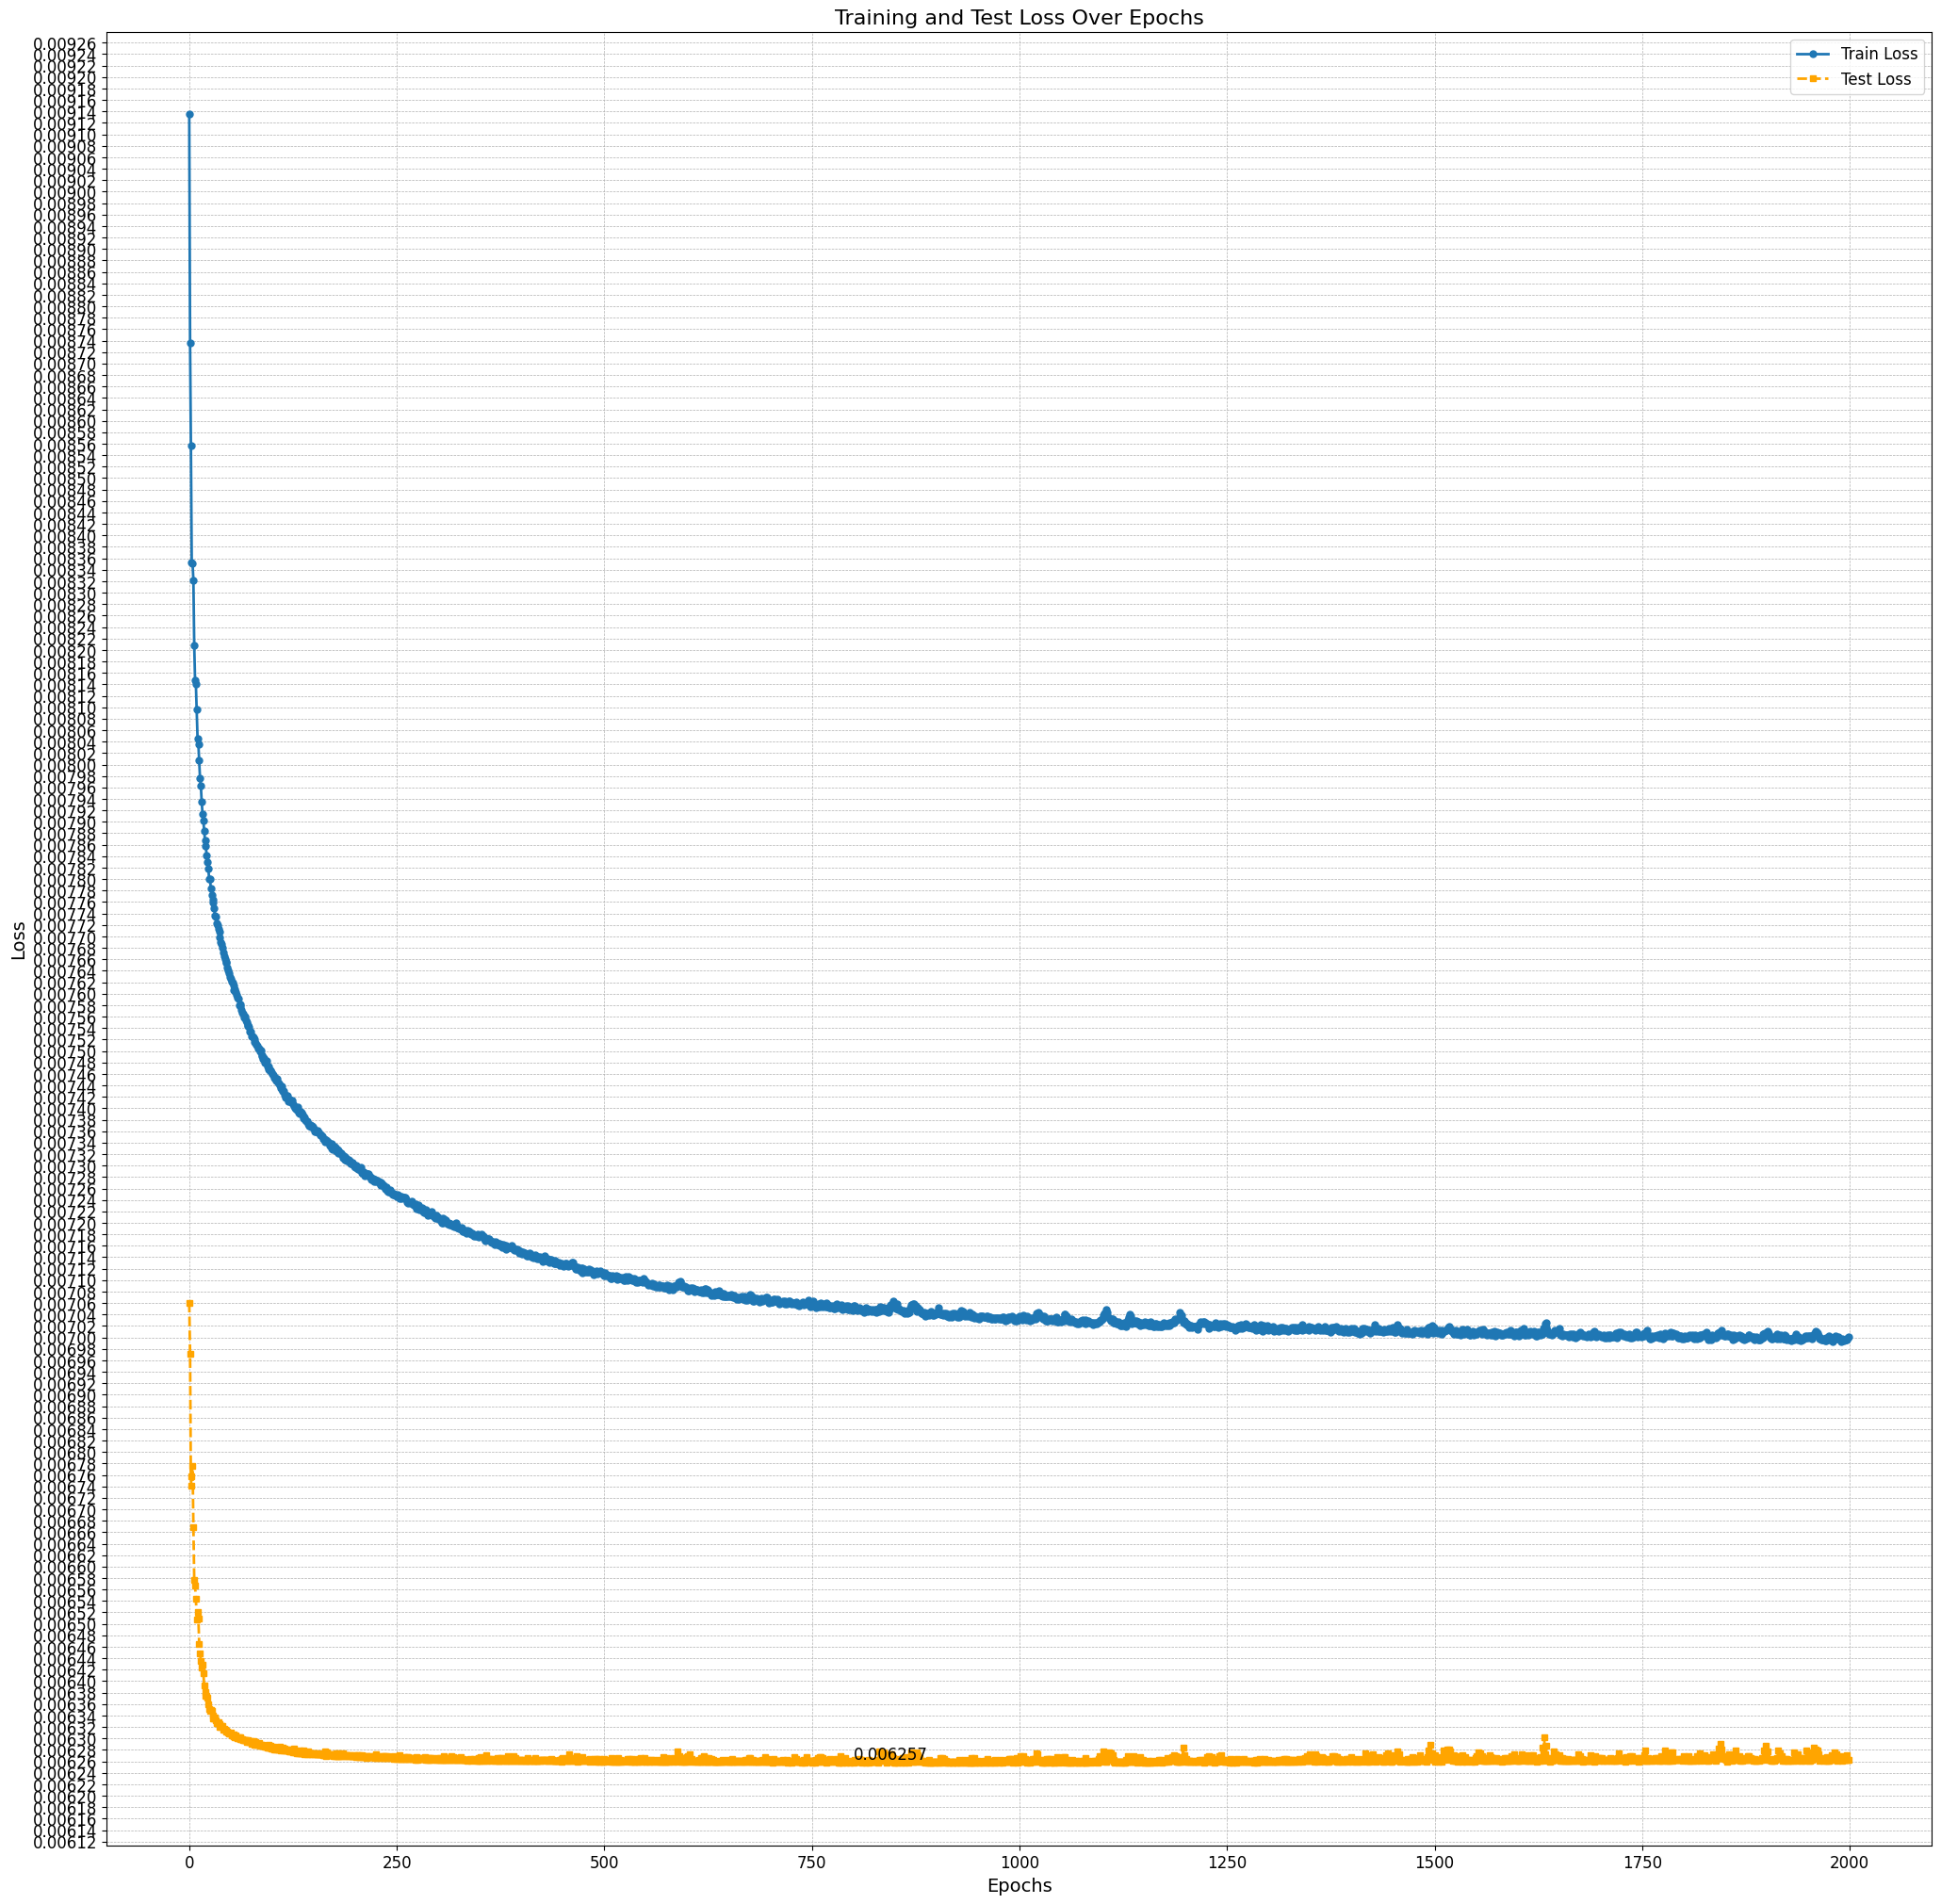

In [ ]:
results_te, predictions, nnse = evaluate(loader_test)
# Convert the TensorFlow tensor to a NumPy array
predictions = predictions.numpy()

true_labels_test = np.hstack([one_graph_labels.y for one_graph_labels in test_graphs])
print("NNSE:", nnse)


# Plotting train and test losses
plt.figure(figsize=(25, 25))

# Plot training losses
plt.plot(train_losses, label='Train Loss', marker='o', linestyle='-', linewidth=2, markersize=5)
# Plot test losses
plt.plot(test_losses, label='Test Loss', marker='s', linestyle='--', linewidth=2, markersize=5, color='orange')

# Adding title and labels
plt.title('Training and Test Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Adding a legend
plt.legend(loc='upper right', fontsize=12)

# Annotate the minimum test loss point
min_test_loss = min(test_losses)
min_test_loss_epoch = test_losses.index(min_test_loss)
plt.text(min_test_loss_epoch, min_test_loss, f'{min_test_loss:.6f}', fontsize=12, ha='right', va='bottom')

# Adding grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize ticks
plt.xticks(fontsize=12)

# Increase number of y-axis ticks
plt.yticks(fontsize=12)
plt.locator_params(axis='y', nbins=200)  # Increase the number of y-axis bins

# Show the plot
plt.show()

In [ ]:

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))
def normalized_nash_sutcliffe_efficiencySTavg(y_true, y_pred): # axis 0 space 1 time
    NSE = 1 - np.sum (np.square(y_true - y_pred) ) / np.sum( np.square(y_true - np.mean(y_true)) )
    return 1 / ( 2 - NSE)
def normalized_nash_sutcliffe_efficiencySsum(y_true, y_pred): # axis 0 space 1 time
    NSE = 1 - np.sum (np.square(np.sum(y_true,axis=0) - np.sum(y_pred,axis=0) )) / np.sum( np.square(np.sum(y_true,axis=0) - np.mean(np.sum(y_true,axis=0)) ) )
    return 1 / ( 2 - NSE)
def symmetric_mean_absolute_percentage(y_true, y_pred):
    value = 2*abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    # for cases when both ground truth and predicted value are zero
    value = np.where(np.isnan(value), 0, value)
    return np.mean(value)
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))


Y_ACTUAL = true_labels_test
# y = pd.read_pickle('TFT_new.pkl')
# Y_ACTUAL = y['y'].values.reshape(n_time_series,n)
Y_HAT = predictions

MAE = mean_absolute_error(Y_ACTUAL, Y_HAT)
MSE = mean_squared_error(Y_ACTUAL, Y_HAT)
NNSE = normalized_nash_sutcliffe_efficiencySTavg(Y_ACTUAL, Y_HAT)



print("MSE: ", MSE)
print("MAE: ", MAE)
print("NNSE: ", NNSE)





MSE:  0.0062620384
MAE:  0.050901417
NNSE:  0.6174085931850848


In [ ]:

test_actual_y = true_labels_test.sum(axis=0)
test_predicted_y = predictions.sum(axis=0)

# Setting up the plot
plt.figure(figsize=(25, 8))
# Plotting Training and Validation MAE
# plt.plot(index_date_train ,train_actual_y, label='train part')
plt.plot(test_actual_y, label='test part')
plt.plot(test_predicted_y, label='prediction')
plt.title('Log Energy summed over the TEST bins')
plt.xlabel('date')
plt.ylabel('Summed Log Energy')
# plt.grid()
plt.legend()
plt.show()
